# Learning disentangled representations in 'grid-world'

## 1. Preamble

In [12]:
import os

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import time
from IPython import display

try:
    import seaborn as sns
    sns.set()
    print("Set seaborn plotting defaults.")
except:
    print("seaborn not found.")

Set seaborn plotting defaults.


In [13]:
def mk_dir(export_dir, quite=False):
    if not os.path.exists(export_dir):
            try:
                os.makedirs(export_dir)
                print('created dir: ', export_dir)
            except OSError as exc: # Guard against race condition
                 if exc.errno != exc.errno.EEXIST:
                    raise
            except Exception:
                pass
    else:
        print('dir already exists: ', export_dir)

## 2. Defining objects

### GridWorld environment

First I'll define the GridWorld environment to work in.  The basic idea is that the ball is on a 2-d grid with $n$ discrete points in each dimension.  The available actions step the ball one step in each direction (i.e. there are 4 actions: up/down/left/right).

Initally, the observations returned are just an $n \times n$ matrix, with zeros everywhere except where the ball is, which is 1.

In [14]:
class GridWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))       

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,dim=5):

        self.dim = dim

        self.action_space = self.action_space(4)
        self.observation_space = self.observation_space(dim**2)
        
        self.reset()
        
    def reset(self):
        self.ball_coordinates = [random.randrange(self.dim), random.randrange(self.dim)]
        self.state = self.get_state()
        return self.get_observation()
    
    def get_state(self, ball_coordinates=None):
        if ball_coordinates is None:
            ball_coordinates=self.ball_coordinates
            
        state = torch.zeros((self.dim,self.dim))
        state[ball_coordinates[0],ball_coordinates[1]] = 1
        
        return state
    
    def get_observation(self):
        return self.state.flatten()
    
    def step(self,action):

        if action == 0:
            self.ball_coordinates[0] = (self.ball_coordinates[0] + 1)%self.dim
        elif action == 1:
            self.ball_coordinates[0] = (self.ball_coordinates[0] - 1)%self.dim
        elif action == 2:
            self.ball_coordinates[1] = (self.ball_coordinates[1] + 1)%self.dim
        elif action == 3:
            self.ball_coordinates[1] = (self.ball_coordinates[1] - 1)%self.dim
        else:
            raise Exception("Invalid action.")

        self.state = self.get_state()

        return self.get_observation()

Now show a few consecutive states from this gridworld

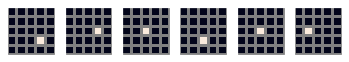

In [15]:
def plot_state(state, ax):
    ax.pcolormesh(env.state, edgecolors='gray', linewidth=2, )
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax
    
n_steps = 5

env = GridWorld()

fig, axs = plt.subplots(1, n_steps+1,)

plot_state(env.state,axs[0])

for i in range(n_steps):
    env.step(np.random.randint(0,4))
    plot_state(env.state,axs[i+1])

### Latent space

**Encoder/Decoder**

Now we want to learn to represent this environment in some latent space (which we, for now, simply assume to be 4-dimensional).  We will require both an encoder and decoder.

In [16]:
class Coder(nn.Module):

    def __init__(self, n_in, n_out, n_hid=[32], output_activation=nn.Sigmoid):
        super().__init__()
        
        if type(n_hid) != list:
            n_hid = [n_hid]
        n_layers = [n_in] + n_hid + [n_out]

        self.layers = []
        for i_layer, (n1, n2) in enumerate(zip(n_layers, n_layers[1:])):
            mods = [nn.Linear(n1, n2, bias=True)]
            act_fn = nn.ReLU if i_layer < len(n_layers) - 2 else output_activation
            if act_fn is not None:
                mods.append(act_fn())
            layer = nn.Sequential(*mods)
            self.layers.append(layer)

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class nnNorm(nn.Module):
    
    def __init__(self, dim=-1):
        super().__init__()
        self.dim=dim
        
    def forward(self, x):
        return F.normalize(x, dim=self.dim)
    
class Decoder(Coder):

    def __init__(self, n_in, n_out, n_hid=[32]):
        super().__init__(n_in, n_out, n_hid, output_activation=nn.Sigmoid)
        
class Encoder(Coder):

    def __init__(self, n_in, n_out, n_hid=[32]):
        super().__init__(n_in, n_out, n_hid, output_activation=nnNorm)

In [17]:
encoder = Encoder(n_in=5*5, n_out=4, n_hid=[32])
print(encoder)

decoder = Decoder(n_in=4, n_out=5*5, n_hid=[32])
print(decoder)

Encoder(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=25, out_features=32, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=4, bias=True)
      (1): nnNorm()
    )
  )
)
Decoder(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=25, bias=True)
      (1): Sigmoid()
    )
  )
)


Check to make sure dimensions are okay.

In [18]:
x = torch.rand(25)
z = encoder(x)
x_recon = decoder(z)
print("Observable rep (shape = {}) : \n {}".format(x.shape, x))
print("Latent rep (shape = {}, norm = {}) : \n {}".format(z.shape, torch.norm(z), z))
print("Reconstructed Observable rep (shape = {}) : \n {}".format(x_recon.shape, x_recon))

Observable rep (shape = torch.Size([25])) : 
 tensor([0.2276, 0.8350, 0.4096, 0.0760, 0.1850, 0.5055, 0.7176, 0.2933, 0.2344,
        0.8434, 0.6855, 0.8067, 0.9070, 0.0959, 0.9930, 0.4419, 0.1822, 0.0209,
        0.8426, 0.0186, 0.0328, 0.8303, 0.1454, 0.4505, 0.5542])
Latent rep (shape = torch.Size([4]), norm = 0.9999999403953552) : 
 tensor([ 0.3447,  0.0625, -0.9034, -0.2474], grad_fn=<DivBackward0>)
Reconstructed Observable rep (shape = torch.Size([25])) : 
 tensor([0.4819, 0.5674, 0.5033, 0.4692, 0.4724, 0.3850, 0.4723, 0.4560, 0.5078,
        0.4804, 0.4849, 0.5639, 0.5185, 0.4518, 0.5257, 0.4698, 0.5441, 0.4963,
        0.5146, 0.4765, 0.5287, 0.4546, 0.4676, 0.5099, 0.5143],
       grad_fn=<SigmoidBackward>)


**Representation**

The crux of the matter is learning to 'represent' actions in the observation space with actions in latent space.  Here, we will do this by assuming every action is a generalized rotation in latent space, which we denote with a series of 2-dimensional rotations.

A 2-d rotation is given by:

\begin{pmatrix}
\cos(\theta) & \sin(\theta) \\
-\sin(\theta) & \cos(\theta)
\end{pmatrix}

and we denote a rotation in dimensions $i$ and $j$ of a higher dimensional space as $R_{i,j}(\theta)$.  For $i=1$, $j=4$, in a 4-dimensional space:

\begin{equation}
R_{1,4}(\theta) = 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & \sin(\theta) \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
-\sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix}
\end{equation}

An arbitrary rotation, denoted $g$ as I am subtly moving towards this being a group action, can then be written as:

\begin{equation}
    g(\theta_{1,2},\theta_{1,3},\dots,\theta_{n-1,n}) = \prod_{i=1}^{n-1} \prod_{j=1+1}^{n} R_{i,j}(\theta_{i,j})
\end{equation}

which has $n(n-1)/2$ free parameters (i.e. $\theta_{i,j}$'s).

In [19]:
class Representation():

    def __init__(self, dim=4):
        self.dim = dim
        self.params = dim*(dim-1)//2
        self.thetas = torch.autograd.Variable(torch.rand(self.params)/dim, requires_grad=True)

        self.__matrix = None
    
    def set_thetas(self, thetas):
        self.thetas = thetas
        self.thetas.requires_grad = True
        self.clear_matrix()
    
    def clear_matrix(self):
        self.__matrix = None
        
    def get_matrix(self):
        if self.__matrix is None:
            k = 0
            mats = []
            for i in range(self.dim-1):
                for j in range(self.dim-1-i):
                    theta_ij = self.thetas[k]
                    k+=1
                    c, s = torch.cos(theta_ij), torch.sin(theta_ij)

                    rotation_i = torch.eye(self.dim, self.dim)
                    rotation_i[i, i] = c
                    rotation_i[i, i+j+1] = s
                    rotation_i[j+i+1, i] = -s
                    rotation_i[j+i+1, j+i+1] = c

                    mats.append(rotation_i)

            def chain_mult(l):
                if len(l)>=3:
                    return l[0]@l[1]@chain_mult(l[2:])
                elif len(l)==2:
                    return l[0]@l[1]
                else:
                    return l[0]

            self.__matrix = chain_mult(mats)
                                    
        return self.__matrix

**LatentWorld**

Now, for symmetry's sake, we'll also have a `LatentWorld` which acts as the environment in the latent space.

In [20]:
class LatentWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,
                 dim=4,
                 n_actions=4,
                 action_reps=None):

        self.dim = dim

        self.action_space = self.action_space(n_actions)
        self.observation_space = self.observation_space(dim)
        
        if action_reps is None:
            self.action_reps = [Representation(dim=self.dim) for _ in range(n_actions)]
        else:
            if len(action_reps)!=n_actions:
                raise Exception("Must pass an action representation for every action.")
            if not all([rep.dim==self.dim]):
                raise Exception("Action representations do not act on the dimension of the latent space.")
            self.action_reps = action_reps
        
    def reset(self, state_init):
        self.state = state_init
        return self.get_observation()
    
    def clear_representations(self):
        for rep in self.action_reps:
            rep.clear_matrix()
            
    def get_representation_params(self):
        params = []
        for rep in self.action_reps:
            params.append(rep.thetas)
        return params
    
    def save_representations(self, path):
        if os.path.splitext(path)[-1] != '.pth':
            path += '.pth'
        rep_thetas = [rep.thetas for rep in self.action_reps]
        return torch.save(rep_thetas, path)
    
    def load_reprentations(self, path):
        rep_thetas = torch.load(path)
        for rep in self.action_reps:
            rep.set_thetas(rep_thetas.pop(0))
            
    def get_observation(self):
        return self.state
    
    def step(self,action):
        self.state = torch.mv(self.action_reps[action].get_matrix(), self.state)
        obs = self.get_observation()
        return obs

## 3. Training

So the basic training loop is pretty straightfoward.  We simply play out episodes from random starting configurations, encoded by the `Encoder`, for `ep_steps` time-steps.  Each random action is executed in both the `GridWorld` and the `LatentWorld`, and then the latent state is transformed to the observation space by the `Decoder` where the loss function measures its deviation from the true state.

In [32]:
obs_env = GridWorld(dim = 11)
lat_env = LatentWorld(dim = 4,
                      n_actions = obs_env.action_space.n)
decoder = Decoder(n_in = sum(lat_env.observation_space.shape),
                  n_out = sum(obs_env.observation_space.shape),
                  n_hid = [32])
encoder = Encoder(n_in = sum(obs_env.observation_space.shape),
                  n_out = sum(lat_env.observation_space.shape),
                  n_hid = [32])

optimizer_dec = optim.Adam(decoder.parameters(),
                           lr=2e-2,
                           weight_decay=0)

optimizer_enc = optim.Adam(encoder.parameters(),
                           lr=5e-2,
                           weight_decay=0)

optimizer_rep = optim.Adam(lat_env.get_representation_params(),
                           lr=2e-2,
                           weight_decay=0)

losses = []

In [33]:
n_sgd_steps = 5000
ep_steps = 10
batch_eps = 16

i = 0

t_start = time.time()

temp = 0

while i < n_sgd_steps:
    
    loss = torch.zeros(1)
    
    for _ in range(batch_eps):
        t_ep = -1
        while t_ep < ep_steps:
            if t_ep == -1:
                obs_x = obs_env.reset()
                obs_z = lat_env.reset(encoder(obs_x))
            else:
                action = obs_env.action_space.sample().item()
                obs_x = obs_env.step(action)
                obs_z = lat_env.step(action)
            
            t_ep += 1         
            
            obs_x_recon = decoder(obs_z)

            loss += F.binary_cross_entropy(obs_x_recon, obs_x)
        
    loss /= (ep_steps*batch_eps)
                        
    losses.append(loss.item())
    
    optimizer_dec.zero_grad()
    optimizer_enc.zero_grad()
    optimizer_rep.zero_grad()
    loss.backward()
    optimizer_enc.step()
    optimizer_dec.step()
    optimizer_rep.step()
        
    # Rember to clear the cached action representations after we update the parameters!
    lat_env.clear_representations()

    i+=1
    
    if i%10==0:
        print("iter {} : loss={:.3f} : last 10 iters in {:.3f}s".format(i, loss.item(), time.time() - t_start),
              end="\r" if i%100 else "\n")
        t_start = time.time()

iter 100 : loss=0.052 : last 10 iters in 0.570s
iter 200 : loss=0.053 : last 10 iters in 0.700s
iter 300 : loss=0.053 : last 10 iters in 0.590s
iter 400 : loss=0.053 : last 10 iters in 0.603s
iter 500 : loss=0.053 : last 10 iters in 0.812s
iter 600 : loss=0.052 : last 10 iters in 0.631s
iter 700 : loss=0.049 : last 10 iters in 0.575s
iter 800 : loss=0.038 : last 10 iters in 0.729s
iter 900 : loss=0.035 : last 10 iters in 0.647s
iter 1000 : loss=0.033 : last 10 iters in 0.550s
iter 1100 : loss=0.032 : last 10 iters in 0.692s
iter 1200 : loss=0.034 : last 10 iters in 0.679s
iter 1300 : loss=0.033 : last 10 iters in 0.623s
iter 1400 : loss=0.031 : last 10 iters in 0.556s
iter 1500 : loss=0.032 : last 10 iters in 0.582s
iter 1600 : loss=0.029 : last 10 iters in 0.555s
iter 1700 : loss=0.022 : last 10 iters in 0.561s
iter 1800 : loss=0.017 : last 10 iters in 0.590s
iter 1900 : loss=0.014 : last 10 iters in 0.606s
iter 2000 : loss=0.009 : last 10 iters in 0.599s
iter 2100 : loss=0.006 : last

**Plot training curve, then save the network**

dir already exists:  _data


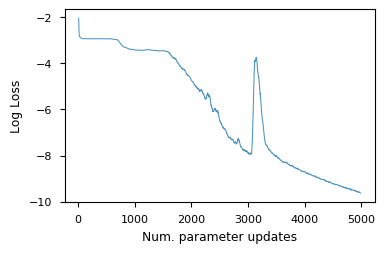

In [34]:
mk_dir("_data")

with plt.style.context('seaborn-paper', after_reset=True):

    fig, ax1 = plt.subplots(1, 1, figsize=(4, 2.5))

    window = 25
    avg_mask = np.ones(window) / window

    ax1.plot(np.convolve(range(len(losses)), avg_mask, 'valid'),
             np.convolve(np.log(losses), avg_mask, 'valid'),
             linewidth=0.75,
             alpha=0.8)
#     ax1.set_yscale("log")

    ax1.set_xlabel("Num. parameter updates")
    ax1.set_ylabel("Log Loss")
    
    fig_fname = "_data/training_loss"
    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')

In [35]:
torch.save(decoder.state_dict(), "decoder.pth")
torch.save(encoder.state_dict(), "encoder.pth")
rep_thetas = [rep.thetas for rep in lat_env.action_reps]
torch.save(rep_thetas, "representations.pth")
torch.save(optimizer_dec.state_dict(), "optimizer_dec.pth")
torch.save(optimizer_enc.state_dict(), 'optimizer_enc.pth')
torch.save(optimizer_rep.state_dict(), "optimizer_rep.pth")

## 4. Testing

Testing is easy too, we just play out an episode and see how well the reconstructed image agrees with the ground truth!

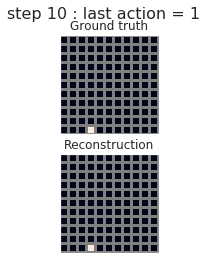

In [36]:
def plot_state(obs, ax, one_hot=True):
    if one_hot:
        obs=(obs == obs.max())
    ax.pcolormesh(obs.reshape(obs_env.dim, obs_env.dim), edgecolors='gray', linewidth=2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax
    
n_steps = 10

fig, (ax1,ax2) = plt.subplots(2, 1)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = obs_env.reset()
        obs_z = lat_env.reset(encoder(obs_x))
    else:
        action = obs_env.action_space.sample().item()
        obs_x = obs_env.step(action)
        obs_z = lat_env.step(action)
        
    obs_x_recon = decoder(obs_z)
    
    fig.suptitle('step {} : last action = {}'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(obs_x_recon.detach().numpy(),ax2, one_hot=False)
    
    fig_fname = "_data/testing_{}".format(i)
    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    
display.clear_output(wait=False)

We will now have a look at the latent space, we will make a 2D projection of the 4D latent space for every possible frame (There are 25 for the 5x5 grid). Note that since we use random projections, in some cases the toric structure we find is more obvious than in others.

**1) Positions on the grid**

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


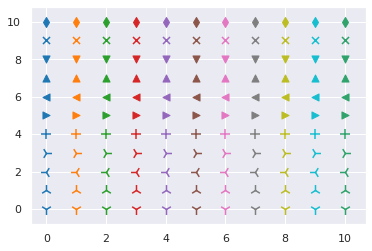

In [56]:
from sklearn.random_projection import GaussianRandomProjection
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')

num_frames = sum(obs_env.observation_space.shape)

latent_points = []

for i in range(num_frames):
    frame = torch.zeros(num_frames)
    frame[i] = 1
    latent = encoder(frame)
    latent_points.append(latent.detach().tolist())

latent_map = np.array(latent_points)

pca = GaussianRandomProjection(n_components=2)

latent_2d = pca.fit_transform(latent_map)

#color=["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',"#2fa36b"]
marks=["1","2","3","4","+",">","<","^","v","x","d"]

s=[120]*5+[50]*6

for i in range (121):
    ax.scatter(x=i//11,
                y=i%11,
   #             zs=latent_2d.transpose()[2][i],
                c=color[i//11], 
                s=s[i%11],
                marker=marks[i%11])

fig.show()



**2) Positions in Latent Space**

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


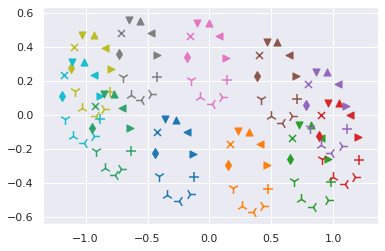

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')
s=[120]*5+[50]*6
for i in range (121):
    ax.scatter(x=latent_2d.transpose()[0][i],
                y=latent_2d.transpose()[1][i],
             #   zs=latent_2d.transpose()[2][i],
                c=color[i//11], 
                s=s[i%11],
                marker=marks[i%11])
 #   ax.set_xlim(-.6/1.4,.6/1.4)
  #  ax.set_ylim(-.8/1.4,.8/1.4)
  #  ax.set_zlim(-1./1.6,1./1.6)
    #ax.view_init(elev=45, azim=45)
fig.show()



**3) Action representations**

tensor([[ 9.9579e-01,  4.8671e-02, -1.0400e-02, -7.7021e-02],
        [ 1.8457e-04,  8.4638e-01,  5.7666e-02,  5.2944e-01],
        [ 7.6437e-03, -3.2625e-02,  9.9784e-01, -5.6531e-02],
        [ 9.1382e-02, -5.2934e-01,  2.9749e-02,  8.4295e-01]],
       grad_fn=<MmBackward>)
tensor([[ 0.9479,  0.3146, -0.0212,  0.0445],
        [ 0.2891, -0.8983,  0.1785,  0.2786],
        [-0.0129,  0.1309,  0.9733, -0.1882],
        [ 0.1330, -0.2774, -0.1428, -0.9407]], grad_fn=<MmBackward>)
tensor([[ 9.9586e-01, -2.6203e-04,  7.9329e-03,  9.0605e-02],
        [ 4.8668e-02,  8.4621e-01, -3.2750e-02, -5.2961e-01],
        [-1.0613e-02,  5.7657e-02,  9.9785e-01,  2.9444e-02],
        [-7.6099e-02,  5.2972e-01, -5.6289e-02,  8.4288e-01]],
       grad_fn=<MmBackward>)
tensor([[ 0.9488,  0.2862, -0.0109,  0.1332],
        [ 0.3117, -0.8996,  0.1303, -0.2767],
        [-0.0222,  0.1774,  0.9734, -0.1434],
        [ 0.0460,  0.2780, -0.1882, -0.9408]], grad_fn=<MmBackward>)
tensor([[ 0.8455, -0.0672, -0.

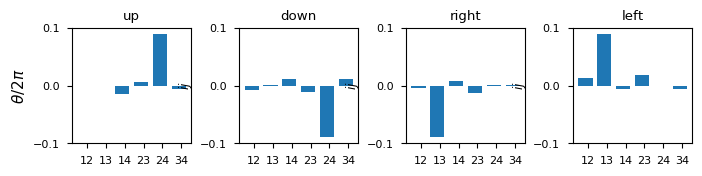

In [58]:
width=0.75

test_folder="_data"

for rep in lat_env.action_reps:
    print(rep.get_matrix())
    print(torch.matrix_power(rep.get_matrix(), 5))
rep_thetas = [rep.thetas.detach().numpy() for rep in lat_env.action_reps]

plt_lim = max( 0.1, max([max(t) for t in rep_thetas])/(2*np.pi) )
titles = ["up", "down", "right", "left"]

with plt.style.context('seaborn-paper', after_reset=True):

    fig, axs = plt.subplots(1, len(rep_thetas), figsize=(8, 1.5), gridspec_kw={"wspace":0.4})
    
    for i, thetas in enumerate(rep_thetas):
        x = np.arange(len(thetas))
        axs[i].bar(x - width/2, thetas/(2*np.pi), width, label='Rep {}'.format(i))
        
        axs[i].set_xticks(x-0.25)
        axs[i].set_xticklabels(["12","13","14","23","24","34"])
        axs[i].set_ylabel("$ij$")
        
        axs[i].set_ylim(-plt_lim,plt_lim)
        
        axs[i].set_title(titles[i])
        
    axs[0].set_ylabel(r"$\theta / 2\pi$", fontsize=11)
    
    fig_fname = os.path.join(test_folder, "thetas")

    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')

## 5. Disentanglement

***Some jargon***

It's nice that it works, but the real point here is to try and learn a *disentangled* representation of the actions.

Before considering how best to do this, we want to define a metric of 'disentanglement'.  We consider the evolution of an observable (latent) vector, $x \in X$ ($z \in Z$), under the element $g \in G$ of the group of symmetries generating transformations of the object.  Then we are looking for a representation, $\rho:G \rightarrow GL(V)$, such that the transformation is linear in the latent space, i.e.
\begin{equation}
    z^{\prime} = \rho(g) \cdot z.
\end{equation}
Note, in our case, the representations are the rotation matrices we learn.

For this representation to be disentangled, it means that if there exists a subgroup decomposition of $G$
\begin{equation}
    G = G_1 \times G_2 \times \dots \times G_n,
\end{equation}
then we equivalently decompose the representation, $(\rho, G)$, into subrepresentations:
\begin{equation}
    V = V_1 \oplus V_2 \oplus \dots \oplus V_n
\end{equation}
such that the restricted subrepresentations $(\rho_{\vert G_i}, V_i)_i$ are non-trivial, and the restricted subrepresentations $(\rho_{\vert G_i}, V_j)_{j \neq i}$ are trivial.

In our context, a GridWorld with 5 points in each dimension is represented by $G = C_5 \times C_5$ (where $C_5$ is the cyclic group).  This is a subgroup of $\mathrm{SO}(2) \times \mathrm{SO}(2)$, therefore we hope to find the disentangled representation of the actions (up, down, left, right) that corresponds to this.

***Some practicalities***

Our intuition is that the disentangled representation acts as the identity on as many dimensions as possible.  We could attempt to enforce this with some regularization during training.  Normal weight decay won't cut it, as that tries to reduce all weights, where as what we really want to do is have all *but one* of our thetas (which corresponds to the rotation/coupling of two dimensions) to be zero.

**1. Entanglement regularisation**

So for $m$ parameters, ${\theta_1, \dots, \theta_m}$, we want to regularise with
\begin{equation}
    \sum_{i \neq j} \vert\theta_i\vert^2, \mathrm{where\ } \theta_j {=} \mathrm{max_k}({\vert\theta_k\vert}).
\end{equation}
We will also use this term as our metric of 'entanglement'.

In [59]:
def calc_entanglement(params):
    params = params.abs().pow(2)
    return params.sum() - params.max()

params = torch.FloatTensor([1,1,0.5,0,0])
calc_entanglement(params)

tensor(1.2500)

### Training with regularization

In [60]:
obs_env = GridWorld(dim = 5)
lat_env = LatentWorld(dim = 4,
                      n_actions = obs_env.action_space.n)
decoder = Decoder(n_in = sum(lat_env.observation_space.shape),
                  n_out = sum(obs_env.observation_space.shape),
                  n_hid = [32])
encoder = Encoder(n_in = sum(obs_env.observation_space.shape),
                  n_out = sum(lat_env.observation_space.shape),
                  n_hid = [32])

optimizer_enc = optim.Adam(encoder.parameters(),
                           lr=2e-2,
                           weight_decay=0)

optimizer_dec = optim.Adam(decoder.parameters(),
                           lr=2e-2,
                           weight_decay=0)

optimizer_rep = optim.Adam(lat_env.get_representation_params(),
                           lr=2e-2,
                           weight_decay=0)

losses = []
entanglement = []

In [61]:
n_sgd_steps = 5000
ep_steps = 5
batch_eps = 2

i = 0

t_start = time.time()

temp = 0

while i < n_sgd_steps:
    
    loss = torch.zeros(1)
    
    for _ in range(batch_eps):
        t_ep = -1
        while t_ep < ep_steps:
            if t_ep == -1:
                obs_x = obs_env.reset()
                obs_z = lat_env.reset(encoder(obs_x))
            else:
                action = obs_env.action_space.sample().item()
                obs_x = obs_env.step(action)
                obs_z = lat_env.step(action)
            
            t_ep += 1         
            
            obs_x_recon = decoder(obs_z)
            #(obs_x_recon==obs_x_recon.max()).float()

            loss += F.binary_cross_entropy(obs_x_recon, obs_x)
        
    loss /= (ep_steps * batch_eps)
    raw_loss = loss.item()
    
    reg_loss = sum([calc_entanglement(r.thetas) for r in lat_env.action_reps])/4
    
    loss += reg_loss * 4e-2
                        
    losses.append(raw_loss)
    entanglement.append(reg_loss.item())
    
    optimizer_dec.zero_grad()
    optimizer_enc.zero_grad()
    optimizer_rep.zero_grad()
    loss.backward()
    optimizer_enc.step()
    optimizer_dec.step()
    optimizer_rep.step()
        
    # Remember to clear the cached action representations after we update the parameters!
    lat_env.clear_representations()

    i+=1
    
    if i%10==0:
        print("iter {} : loss={:.3f} : entanglement={:.2e} : last 10 iters in {:.3f}s".format(
            i, raw_loss, reg_loss.item(), time.time() - t_start
            ), end="\r" if i%100 else "\n")
        t_start = time.time()

iter 100 : loss=0.199 : entanglement=9.13e-04 : last 10 iters in 0.097s
iter 200 : loss=0.215 : entanglement=2.20e-03 : last 10 iters in 0.165s
iter 300 : loss=0.193 : entanglement=1.27e-02 : last 10 iters in 0.093s
iter 400 : loss=0.200 : entanglement=4.60e-02 : last 10 iters in 0.110s
iter 500 : loss=0.154 : entanglement=4.31e-02 : last 10 iters in 0.216s
iter 600 : loss=0.155 : entanglement=1.46e-02 : last 10 iters in 0.112s
iter 700 : loss=0.093 : entanglement=1.78e-02 : last 10 iters in 0.144s
iter 800 : loss=0.036 : entanglement=1.52e-02 : last 10 iters in 0.166s
iter 900 : loss=0.009 : entanglement=3.21e-03 : last 10 iters in 0.156s
iter 1000 : loss=0.012 : entanglement=4.33e-03 : last 10 iters in 0.157s
iter 1100 : loss=0.002 : entanglement=1.69e-04 : last 10 iters in 0.133s
iter 1200 : loss=0.001 : entanglement=6.21e-05 : last 10 iters in 0.166s
iter 1300 : loss=0.001 : entanglement=2.38e-05 : last 10 iters in 0.176s
iter 1400 : loss=0.001 : entanglement=1.67e-05 : last 10 ite

In [62]:
exp_name = "ent_reg_1e-2_orthNorm_reg_1e-2_v10"
# exp_name = "testing"

save_folder = os.path.join("_data/decoder_only", exp_name)
train_folder = os.path.join(save_folder,"train")
test_folder = os.path.join(save_folder,"test")

mk_dir(save_folder)
mk_dir(train_folder)
mk_dir(test_folder)

created dir:  _data/decoder_only/ent_reg_1e-2_orthNorm_reg_1e-2_v10
created dir:  _data/decoder_only/ent_reg_1e-2_orthNorm_reg_1e-2_v10/train
created dir:  _data/decoder_only/ent_reg_1e-2_orthNorm_reg_1e-2_v10/test


**Show training curves**

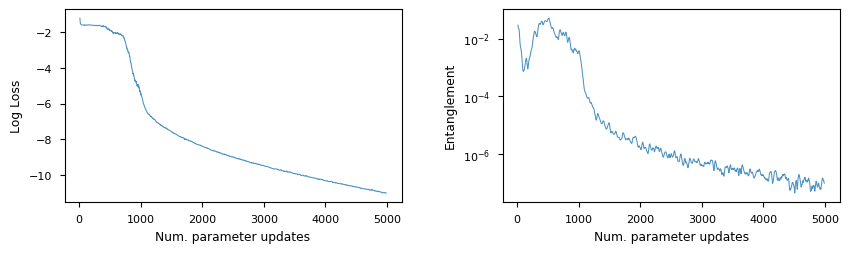

In [63]:
with plt.style.context('seaborn-paper', after_reset=True):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5), gridspec_kw={"wspace":0.3})

    window = 25
    avg_mask = np.ones(window) / window

    ax1.plot(np.convolve(range(len(losses)), avg_mask, 'valid'),
             np.convolve(np.log(losses), avg_mask, 'valid'),
             linewidth=0.75,
             alpha=0.8)
#     ax1.set_yscale("log")

    ax1.set_xlabel("Num. parameter updates")
    ax1.set_ylabel("Log Loss")
    
    ax2.plot(np.convolve(range(len(entanglement)), avg_mask, 'valid'),
             np.convolve(entanglement, avg_mask, 'valid'),
             linewidth=0.75,
             alpha=0.8)
    ax2.set_yscale("log")

    ax2.set_xlabel("Num. parameter updates")
    ax2.set_ylabel("Entanglement")
    
    fig_fname = os.path.join(train_folder, "training_curves")
    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')

In [64]:
torch.save(decoder.state_dict(), os.path.join(save_folder,"decoder.pth"))
rep_thetas = [rep.thetas for rep in lat_env.action_reps]
torch.save(rep_thetas, os.path.join(save_folder,"representations.pth"))
torch.save(optimizer_dec.state_dict(), os.path.join(train_folder,"optimizer_dec.pth"))
torch.save(optimizer_rep.state_dict(), os.path.join(train_folder,"optimizer_rep.pth"))

### Testing: action representations

tensor([[ 1.0000e+00, -3.5087e-06,  1.9758e-05, -2.0835e-04],
        [ 3.5050e-06,  1.0000e+00,  1.2315e-06, -1.7730e-05],
        [ 1.9206e-04,  1.6482e-05,  3.0882e-01,  9.5112e-01],
        [ 8.3135e-05,  6.6463e-06, -9.5112e-01,  3.0882e-01]],
       grad_fn=<MmBackward>)
tensor([[ 1.0000e+00, -1.7534e-05, -9.4384e-08, -1.5931e-07],
        [ 1.7534e-05,  1.0000e+00, -5.6509e-09, -1.4922e-08],
        [ 9.4558e-08,  5.6586e-09,  1.0000e+00,  1.0403e-03],
        [ 1.5922e-07,  1.4915e-08, -1.0403e-03,  1.0000e+00]],
       grad_fn=<MmBackward>)
tensor([[ 1.0000e+00, -5.7681e-05,  1.4653e-04,  9.0537e-05],
        [ 5.7667e-05,  1.0000e+00, -3.5167e-06,  1.6471e-04],
        [ 4.0847e-05,  1.5774e-04,  3.0895e-01, -9.5108e-01],
        [-1.6734e-04, -4.7534e-05,  9.5108e-01,  3.0895e-01]],
       grad_fn=<MmBackward>)
tensor([[ 1.0000e+00, -2.8829e-04, -1.1642e-08,  2.5597e-08],
        [ 2.8829e-04,  1.0000e+00,  7.7860e-09,  2.5170e-08],
        [ 1.1671e-08, -7.7921e-09,  1.0000

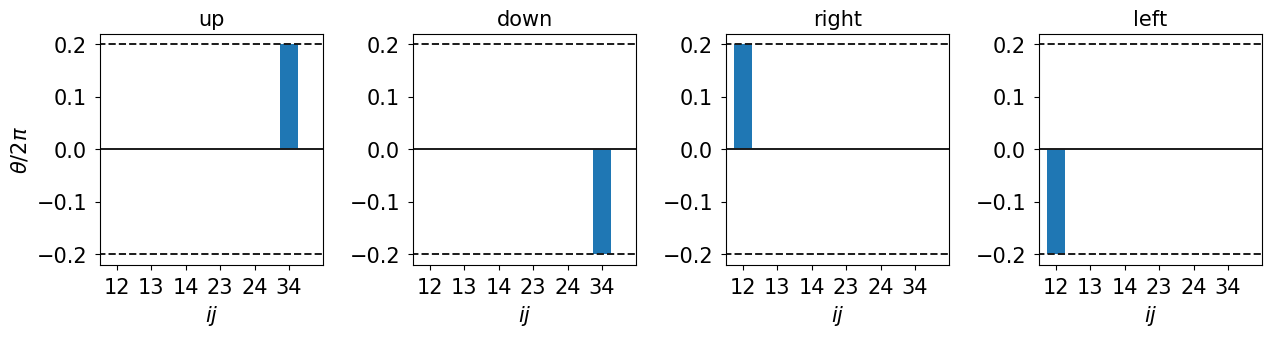

In [65]:
width=0.5

rep_thetas = [rep.thetas.detach().numpy() for rep in lat_env.action_reps]

for rep in lat_env.action_reps:
    print(rep.get_matrix())
    print(torch.matrix_power(rep.get_matrix(), 5))

plt_lim = max( 0.22, max([max(t) for t in rep_thetas])/(2*np.pi) )
titles = ["up", "down", "right", "left"]

with plt.style.context('seaborn-paper', after_reset=True):

    fig, axs = plt.subplots(1, len(rep_thetas), figsize=(15, 3), gridspec_kw={"wspace":0.4})
    
    for i, thetas in enumerate(rep_thetas):
        x = np.arange(len(thetas))
        axs[i].bar(x - width/2, thetas/(2*np.pi), width, label='Rep {}'.format(i))
        axs[i].hlines((0.2,-0.2), -2., 7., linestyles="dashed")
        axs[i].hlines(0., -2., 7.)
        axs[i].set_xticks(x-0.25)
        axs[i].set_xticklabels(["12","13","14","23","24","34"], fontsize = 15)
        axs[i].set_xlabel("$ij$", fontsize = 15)
        
        axs[i].set_ylim(-plt_lim,plt_lim)
        axs[i].set_xlim(-.75, 5.75)
        axs[i].set_title(titles[i], fontsize = 15)
        
        axs[i].tick_params(labelsize=15)

    axs[0].set_ylabel(r"$\theta / 2\pi$", fontsize = 15)
    
    fig_fname = os.path.join(test_folder, "thetas")

    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')

**Show predictions made by trained network with disentangled representations**

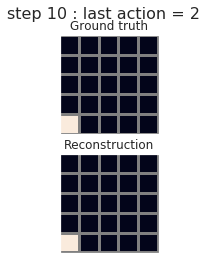

In [66]:
def plot_state(obs, ax, one_hot=True):
    if one_hot:
        obs=(obs == obs.max())
    ax.pcolormesh(obs.reshape(obs_env.dim, obs_env.dim), edgecolors='gray', linewidth=2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax
    
n_steps = 10

fig, (ax1,ax2) = plt.subplots(2, 1)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = obs_env.reset()
        obs_z = lat_env.reset(encoder(obs_x))
    else:
        action = obs_env.action_space.sample().item()
        obs_x = obs_env.step(action)
        obs_z = lat_env.step(action)
        
    obs_x_recon = decoder(obs_z)
    
    fig.suptitle('step {} : last action = {}'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(obs_x_recon.detach().numpy(),ax2, one_hot=False)
    
    fig_fname = os.path.join(test_folder, "step_{}".format(i))

    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    
display.clear_output(wait=False)